In [1]:
import os
import pandas as pd
from glob import glob

# Thresholds
row_threshold = 100_000
feature_threshold = 10

# Group containers
row_groups = {
    "rows>100k": [],
    "rows<=100k": []
}
feature_groups = {
    "features>10": [],
    "features<=10": []
}

# Get list of CSV files
csv_files = glob("stream_datasets/*.csv")

for filepath in csv_files:
    try:
        # Get number of columns
        df_sample = pd.read_csv(filepath)
        num_features = df_sample.shape[1]

        # Get number of rows efficiently
        with open(filepath, 'r') as f:
            num_rows = sum(1 for line in f) - 1  # subtract header

        # Group by rows
        if num_rows > row_threshold:
            row_groups["rows>100k"].append(filepath)
        else:
            row_groups["rows<=100k"].append(filepath)

        # Group by features
        if num_features > feature_threshold:
            feature_groups["features>10"].append(filepath)
        else:
            feature_groups["features<=10"].append(filepath)

    except Exception as e:
        print(f"Error reading {filepath}: {e}")

import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset_less_than_100Krow = [os.path.splitext(os.path.basename(f))[0] for f in row_groups['rows<=100k']]
dataset_more_than_100Krow = [os.path.splitext(os.path.basename(f))[0] for f in row_groups['rows>100k']]

In [3]:
dataset_less_than_10features = [os.path.splitext(os.path.basename(f))[0] for f in feature_groups['features<=10']]
dataset_more_than_10features = [os.path.splitext(os.path.basename(f))[0] for f in feature_groups['features>10']]


In [4]:
real_datasets=[
        'adult',
	    'electricity',
	    'forest_cover',
        'insects',
    	'new_airlines',
        'shuttle',
        'vehicle_sensIT',
      'rialto',
      'weather',
]


syntetic_datasets=[      
      'river_Waveform_2',
      'river_anomalysine',
      'river_Waveform',
      'skmul_aggrawal',
      'skmul_anomalysine_2',
      'river_hyperlane_2',
      'skmul_anomalysine',
      'river_hyperlane',
      'skmul_hyperlane',
      'river_led',
      'skmul_ledgenerator',
      'river_led_default_drift',
      'skmul_ledgenerator_default_drift',
      'river_mixed',
      'skmul_randomRBF_default_drift',
      'river_SEA_2',
      'skmul_randomRBF_gradual',
      'skmul_randomTree_2',
      'river_randomRBF_2',
      'skmul_randomTree',
      'river_randomRBF',
      'river_randomRBF_drift',
      'skmul_SEA_2',
      'river_randomTree_2',
      'skmul_SEA',
      'river_randomTree',
      'skmul_Sine',
      'river_SEA',
      'skmul_STAGGER_2',
      'river_SINE',
      'skmul_STAGGER',
      'river_STAGGER',
      'skmul_Waveform',
      	'synth_RandomRBFDrift',
	    'synth_agrawal',
        'sea_high_abrupt_drift',
	    'sea_high_mixed_drift',
        'movingRBF',
	    'moving_squares',
        'hyperplane_high_gradual_drift',
        'river_aggrawal'
        ]

In [5]:
# import seaborn as sns
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing
import re
from collections import defaultdict
import gc

from utils import downsample, kappa_chan_probs, kappa_no_chan_probs

In [6]:
import matplotlib.pyplot as plt 
import json
from glob import glob

from collections import defaultdict
import os
import numpy as np

import pandas as pd

def get_metrics(dataset_input):
    dataset_names=dataset_input

    model_names=('HATC','ARFC','AutoClass','AutoStreamML','SRPC', 'EvoAutoML',"OnlineAutoML")
    
    
    dataset_by_model={}
    for dataset in dataset_names:
        dataset_by_model[dataset]={}
    
    for model in model_names:
        for dataset in dataset_names:
            dataset_by_model[dataset][model]=glob(f'./experiment-results/{model}/{model}_{dataset}*')


    model_names_for_stats = ('AutoClass', 'AutoStreamML', 'EvoAutoML', 'OnlineAutoML','ARFC','HATC','SRPC')
    
    default_config=True
    
    model_scores = {}
    model_time = {}
    model_energy = {}
    model_kappa = {}
    model_kappa_plus = {}
    
    # Initialize the dictionaries to hold data for each model
    for model in model_names_for_stats:
        model_scores[model] = []
        model_time[model] = []
        model_energy[model] = []
        model_kappa[model] = []
        model_kappa_plus[model] = []
    
    for data_idx, data_name in enumerate(dataset_names):
    
        real_dataset = pd.read_csv(f'stream_datasets/{data_name}.csv')
        class_values = real_dataset['class']
        if len(class_values)>100000:
            window_size=10000
        else:
            window_size=1000
        
        threshold = int(len(class_values) - window_size)
        class_values = class_values[:threshold]
    
        no_change_probabilities = kappa_no_chan_probs(window_size=window_size, class_values=class_values)
        chance_probabilities = kappa_chan_probs(window_size=window_size, class_values=class_values)
    
        for model in model_names_for_stats:
    
            
            for sample in dataset_by_model[data_name][model]:
                if default_config==True:
                    if model == 'AutoClass':
                        if 'population_size_10_exploration_window_1000' not in sample:
                            continue
                    if model == 'AutoStreamML':
                        if 'exploration_window_1000_ensemble_size_3_budget_10' not in sample:
                            continue
                    if model == 'EvoAutoML':
                        if 'population_size_10_sampling_size_1_sampling_rate_1000' not in sample:
                            continue
                    if model == 'OnlineAutoML':
                        if 'default' not in sample:
                            continue
                    if model == 'SRPC' or model =='ARFC' or model=='HATC':
                        if 'nmodel_3' not in sample:
                            continue
    
                with open(sample) as f:
                    data = json.load(f)
    
    
                prequential_scores = np.array(data['prequential_scores'])
                time = np.array(data['time'])
                energy_consumed = np.array(data['energy_consumed'])
    
                if len(prequential_scores) < threshold or len(time) < threshold or len(energy_consumed) < threshold:
                    continue
    
                prequential_scores = prequential_scores[:threshold]
                time = time[:threshold]
                energy_consumed = energy_consumed[:threshold]
    
                energy_consumed *= 3600000  # Convert to proper units
                time *= 1000  # Convert to milliseconds
    
                # Downsample the metrics
                down_prequential_scores = downsample(prequential_scores, window_size)
                down_time = downsample(time, window_size)
                down_energy_consumed = downsample(energy_consumed, window_size)
    
                # Trim the no_change_probabilities to match the downsampled scores length
                no_change_probabilities = no_change_probabilities[:len(down_prequential_scores)]
    
                # Calculate kappa values
                kappa_no_change_down = (down_prequential_scores - no_change_probabilities) / (1 - no_change_probabilities)
                kappa_chance_down = (down_prequential_scores - chance_probabilities) / (1 - chance_probabilities)
    
    
                model_scores[model] = np.concatenate([model_scores[model],         [np.nanmean(down_prequential_scores)]])
                model_time[model] = np.concatenate([model_time[model],             [np.nanmean(down_time)]])
                model_energy[model] = np.concatenate([model_energy[model],         [np.nanmean(down_energy_consumed)]])
                model_kappa[model] = np.concatenate([model_kappa[model],           [np.nanmean(kappa_chance_down)]])
                model_kappa_plus[model] = np.concatenate([model_kappa_plus[model], [np.nanmean(kappa_no_change_down)]])
    
    return {
    'model_scores': model_scores,
    'model_time':  model_time,
    'model_energy': model_energy,
    'model_kappa': model_kappa,
    'model_kappa_plus': model_kappa_plus
}



In [7]:
def get_memory(dataset_names):
    all_mod_mem = {}  
    
    default_config=True
    
    model_names=('AutoClass', 'AutoStreamML', 'EvoAutoML', 'OnlineAutoML','ARFC','HATC','SRPC')
    

    
    dataset_by_model={}
    for dataset in dataset_names:
        dataset_by_model[dataset]={}
    
    for model in model_names:
        for dataset in dataset_names:
               dataset_by_model[dataset][model]=glob(f'./experiment-results/{model}/{model}_{dataset}*')
    
    dataset_length={}
    for data_name in dataset_names:
        real_dataset = pd.read_csv(f'stream_datasets/{data_name}.csv')
        # print(len(real_dataset))
        dataset_length[data_name]=len(real_dataset)
    
    dataset_length_scaled={}
    for data_name in dataset_names:
        dataset_length_scaled[data_name]=dataset_length[data_name]//50000+1
    
    for mod in model_names:
        model_mem = [] 
        
        for datas in dataset_names:
            for sample in dataset_by_model[datas][mod]:

                if default_config==True:
                    if mod == 'AutoClass':
                        if 'population_size_10_exploration_window_1000' not in sample:
                            continue
                    if mod == 'AutoStreamML':
                        if 'exploration_window_1000_ensemble_size_3_budget_10' not in sample:
                            continue
                    if mod == 'EvoAutoML':
                        if 'population_size_10_sampling_size_1_sampling_rate_1000' not in sample:
                            continue
                    if mod == 'OnlineAutoML':
                        if 'default' not in sample:
                            continue
                    if mod == 'SRPC' or model =='ARFC' or model=='HATC':
                        if 'nmodel_3' not in sample:
                            continue
                        
                with open(sample) as f:
                    data = json.load(f)
                memory = np.array(data['memory'])
                total_mem_mb = np.sum(memory) / (1024 * 1024) / dataset_length_scaled[datas]

                model_mem.append(total_mem_mb)
        
        # Store all values for this model
        all_mod_mem[mod] = model_mem

    return all_mod_mem


all_mod_mem_less_than_10 = get_memory(dataset_less_than_10features)
all_mod_mem_more_than_10 = get_memory(dataset_more_than_10features)

In [8]:
import seaborn as sns


def visualise_metrics(metrics,title):
    
    # Loop over each metric
    for metric_name, metric_data in metrics.items():
        # Flatten scores for all models
        all_scores = []
        model_labels = []
    
        for model, scores in metric_data.items():
            # flattened_scores = [score for sublist in scores for score in sublist]
            all_scores.append(scores)
            model_labels.append(model)
    
        # Create a boxplot for the current metric
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=all_scores, showfliers=False)
        titles={
            'model_scores': 'Comparision of Prequential Accuracy of Frameworks',
            'model_time': 'Comparision of Inference Time of Frameworks',
            'model_energy': 'Comparision of Energy Consumption of Frameworks',
            'model_kappa': 'Comparision of Kappa Statistic of Frameworks',
            'model_kappa_plus': 'Comparision of $Kappa^+$ Statistic of Frameworks'
        }
        y_labels={
            'model_scores': 'Accuracy',
            'model_time': 'Inference Time(ms)',
            'model_energy': 'Energy (J)',
            'model_kappa': 'k',
            'model_kappa_plus': '$k^+$'
        }
    
        if metric_name in ['model_scores']:
            # plt.yticks(np.arange(0.0, 1.05, 0.1), fontsize=20)
            plt.ylim(-0.05,1.05)
        elif metric_name in ['model_time']:
            plt.ylim(-0.05,90)
        
    
        # Add grid and increase font size
        plt.title(f'{titles.get(metric_name)} {title}', fontsize=20)
        plt.ylabel(y_labels.get(metric_name), fontsize=20)
        # plt.ylabel(metric_name)
        plt.xticks(range(len(model_labels)), model_labels, fontsize=20,rotation=20)  # Increase font size for x-ticks
        plt.yticks(fontsize=20)  # Increase font size for y-ticks
        plt.grid(True)
    
        # Show the plot for this metric
        plt.show()

In [9]:
import numpy as np
def print_metrics(metrics):
    model_names=('HATC','ARFC','AutoClass','AutoStreamML','SRPC', 'EvoAutoML',"OnlineAutoML")
    
    
    model_scores = metrics['model_scores'] 
    model_time = metrics['model_time'] 
    model_energy = metrics['model_energy'] 
    model_kappa = metrics['model_kappa'] 
    model_kappa_plus = metrics['model_kappa_plus']
 

    for model in model_names:
        # Convert to numpy arrays (if not already) and replace inf with NaN
        scores = np.array(model_scores[model], dtype=np.float64)
        time = np.array(model_time[model], dtype=np.float64)
        energy = np.array(model_energy[model], dtype=np.float64)
        kappa = np.array(model_kappa[model], dtype=np.float64)
        kappa_plus = np.array(model_kappa_plus[model], dtype=np.float64)
    
        # Replace infinity (inf) with NaN so nanmean/nanstd will ignore them
        scores[~np.isfinite(scores)] = np.nan
        time[~np.isfinite(time)] = np.nan
        energy[~np.isfinite(energy)] = np.nan
        kappa[~np.isfinite(kappa)] = np.nan
        kappa_plus[~np.isfinite(kappa_plus)] = np.nan
    
        # Compute mean and std (ignoring NaN and inf)
        mean_score, std_score = np.nanmean(scores), np.nanstd(scores)
        mean_time, std_time = np.nanmean(time), np.nanstd(time)
        mean_energy, std_energy = np.nanmean(energy), np.nanstd(energy)
        mean_kappa, std_kappa = np.nanmean(kappa), np.nanstd(kappa)
        mean_kappa_plus, std_kappa_plus = np.nanmean(kappa_plus), np.nanstd(kappa_plus)
    
        # Print results
        print(f"Model: {model}")
        print(f"  Scores → Mean: {mean_score:.2f}, Std: {std_score:.2f}")
        print(f"  Time → Mean: {mean_time:.2f}, Std: {std_time:.2f}")
        print(f"  Energy → Mean: {mean_energy:.2f}, Std: {std_energy:.2f}")
        print(f"  Kappa → Mean: {mean_kappa:.2f}, Std: {std_kappa:.2f}")
        print(f"  Kappa+ → Mean: {mean_kappa_plus:.2f}, Std: {std_kappa_plus:.2f}")
        print("-" * 50)  # Separator

# Statistical test of pair of Frameworks between dataset groups

In [10]:
metrics_few_features = get_metrics(dataset_less_than_10features)
metrics_many_features = get_metrics(dataset_more_than_10features)




metrics_1= metrics_few_features 
metrics_2= metrics_many_features

metrics_1['memory']=all_mod_mem_less_than_10
metrics_2['memory']=all_mod_mem_more_than_10

In [11]:
from scipy.stats import mannwhitneyu


model_names_for_stats = ('AutoClass', 'AutoStreamML', 'EvoAutoML', 'OnlineAutoML','ARFC','HATC','SRPC')
metric_names_for_stats=(['model_scores','model_kappa_plus','model_time','model_energy','model_kappa','model_kappa_plus','memory'])

total_p=0
for models in model_names_for_stats:
    for metric_name in metric_names_for_stats:
       print(f"Model :{models} ----- Metric: {metric_name}")
       stat, p = mannwhitneyu(metrics_1[metric_name][models], metrics_2[metric_name][models], alternative='two-sided')
       total_p=total_p+p
    #    print(f"{metric_name} comparison: U={stat:.3f}, p={p:.5f}")
       if p < 0.05:
           print("→ Significant difference  ", p)
       else:
           print("→ No significant difference")

Model :AutoClass ----- Metric: model_scores
→ Significant difference   1.4759878994994886e-11
Model :AutoClass ----- Metric: model_kappa_plus
→ Significant difference   2.723176624514837e-07
Model :AutoClass ----- Metric: model_time
→ Significant difference   1.5896128973381432e-19
Model :AutoClass ----- Metric: model_energy
→ Significant difference   4.664396522611365e-20
Model :AutoClass ----- Metric: model_kappa
→ Significant difference   7.891089676358493e-06
Model :AutoClass ----- Metric: model_kappa_plus
→ Significant difference   2.723176624514837e-07
Model :AutoClass ----- Metric: memory
→ No significant difference
Model :AutoStreamML ----- Metric: model_scores
→ Significant difference   5.1228585879574935e-11
Model :AutoStreamML ----- Metric: model_kappa_plus
→ Significant difference   2.0610225900283707e-07
Model :AutoStreamML ----- Metric: model_time
→ Significant difference   8.12614053618567e-23
Model :AutoStreamML ----- Metric: model_energy
→ Significant difference   2.36

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def visualise_metrics(metrics, title):
    metric_order = [
        "model_scores",
        "model_time",
        "model_energy",
        "model_kappa",
        "model_kappa_plus",
        "memory"
    ]

    titles = {
        'model_scores': 'Comparision of Prequential Accuracy of Frameworks',
        'model_time': 'Comparision of Inference Time of Frameworks',
        'model_energy': 'Comparision of Energy Consumption of Frameworks',
        'model_kappa': 'Comparision of Kappa Statistic of Frameworks',
        'model_kappa_plus': 'Comparision of $Kappa^+$ Statistic of Frameworks'
    }
    x_labels = {
        'model_scores': 'Prequential Accuracy',
        'model_time': 'Inference Time (ms)',
        'model_energy': 'Energy Consumption (J)',
        'model_kappa': 'Kappa ($\kappa$)',
        'model_kappa_plus': 'Kappa-plus ($\kappa^+$)',
        'memory': 'Memory (MB)'
    }

    # create 1x5 subplots
    fig, axes = plt.subplots(2, 3, figsize=(24, 8))
    axes = axes.flatten()  # flatten to make indexing easier

    # color palette (consistent across all subplots)
    colors = plt.cm.tab10.colors  

    for idx, metric_name in enumerate(metric_order):
        ax = axes[idx]
        metric_data = metrics.get(metric_name, {})
        all_scores = []
        model_labels = []

        for model, scores in metric_data.items():
            all_scores.append(scores)
            model_labels.append(model)

        # Plot scatter points + means
        for i, (scores, model) in enumerate(zip(all_scores, model_labels)):
            color = colors[i % len(colors)]
            ax.scatter(scores, [i] * len(scores), alpha=0.7, s=20, color=color)
            mean_val = np.median(scores)
            ax.scatter(mean_val, i, color=color, s=150, marker="d",
                       edgecolor="black", linewidth=1.2, zorder=3)

        # axis limits
        if metric_name == 'model_scores':
            ax.set_xlim(-0.05, 1.05)
        elif metric_name == 'model_time':
            ax.set_xlim(-0.05, 90)
        elif metric_name == 'model_energy':
            ax.set_xlim(-0.05, 14)
        elif metric_name == 'model_time':
            ax.set_xlim(-0.05, 86)
        elif metric_name == 'model_kappa':
            ax.set_xlim(-1.1, 1.05)
        elif metric_name == 'model_kappa_plus':
            ax.set_xlim(-1.1, 1.05)
        elif metric_name == 'memory':
            ax.set_xlim(-0.05, 500)


        # labels
        # ax.set_title(f'{titles.get(metric_name)} {title}', fontsize=16)
        ax.set_xlabel(x_labels.get(metric_name), fontsize=22)
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
        ax.grid(True, axis="x",alpha=0.9)

        # y-axis only on the first subplot
        if idx == 0 or idx == 3:
            ax.set_yticks(range(len(model_labels)))
            # replace "AutoStreamML" with "ASML" without modifying original list
            labels = [lab.replace("AutoStreamML", "ASML") for lab in model_labels]
            ax.set_yticklabels(labels, fontsize=20)
        else:
            ax.set_yticks(range(len(model_labels)))
            ax.set_yticklabels([])  # hide labels, keep ticks aligned
    # plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()


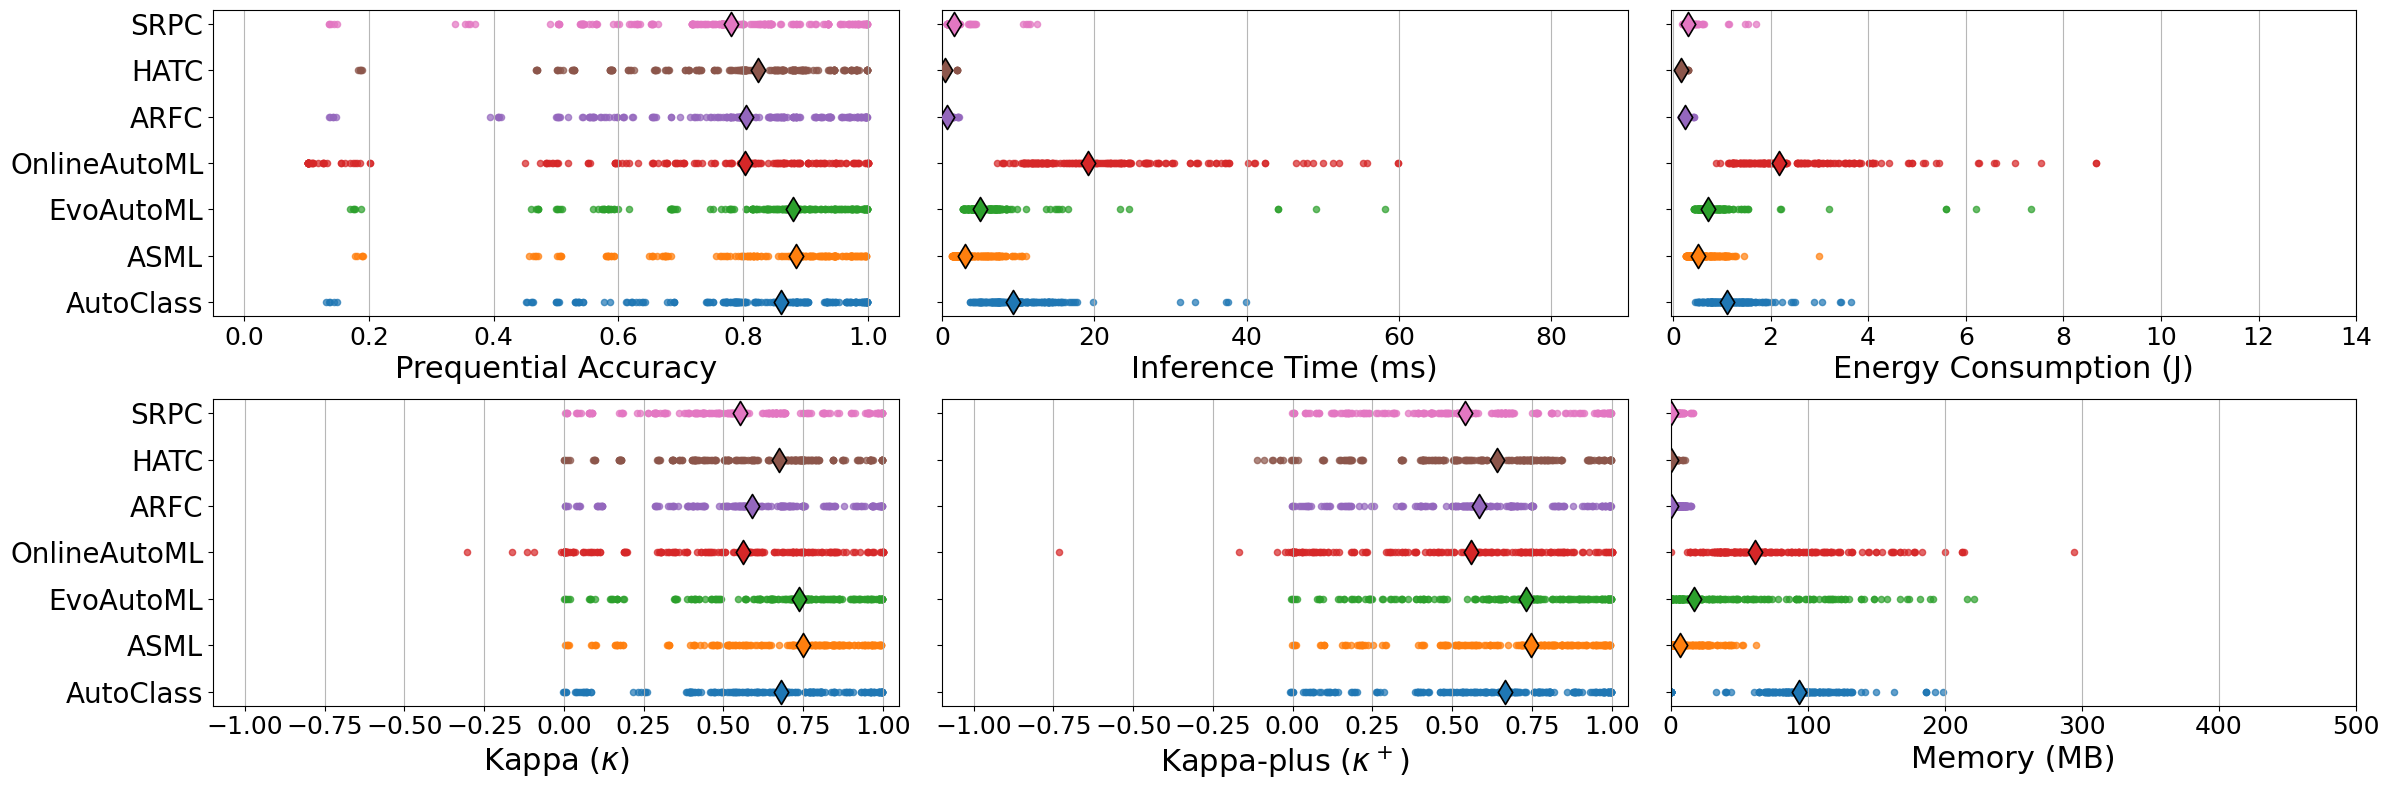

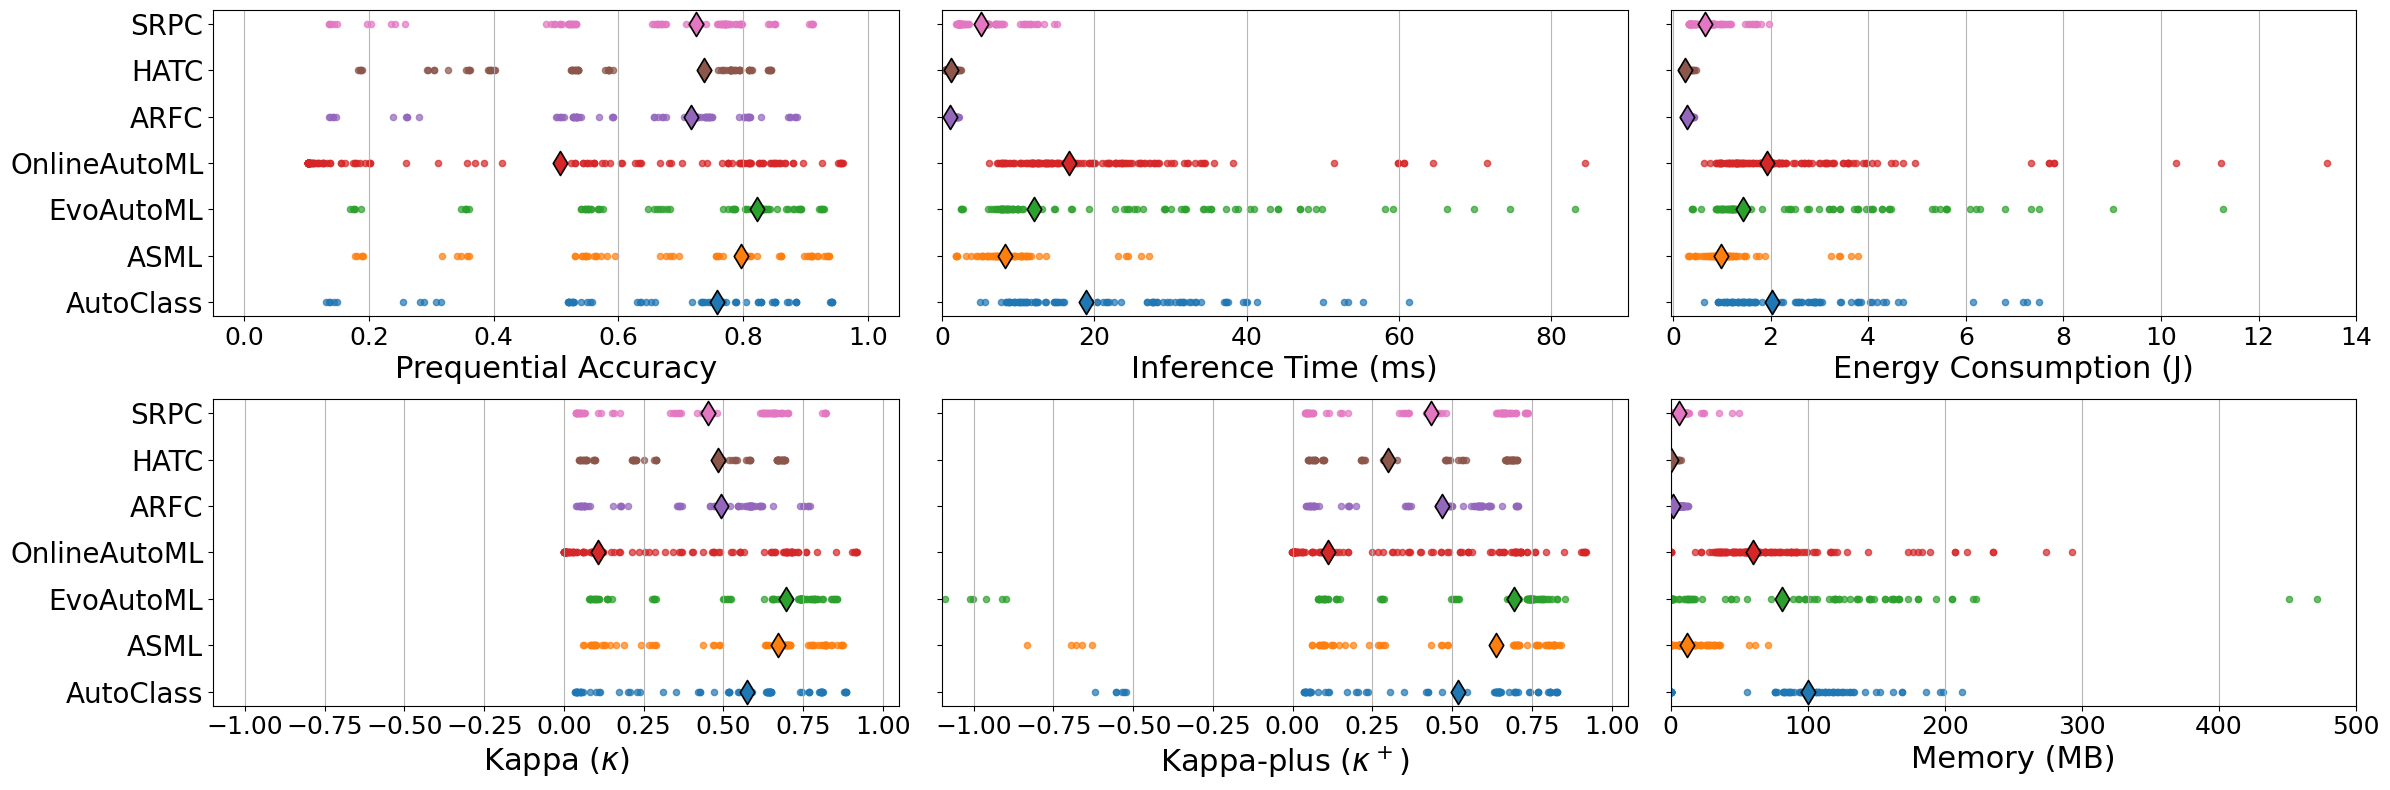

In [13]:
visualise_metrics(metrics_1,"Result on datasets with less than 10 feature")
visualise_metrics(metrics_2,"Result on datasets with more than 10 feature")

In [14]:
print("Less than 10")
print_metrics(metrics_1)
print("\n")
print(50*"=")
print("\n")
print("More than 10")
print_metrics(metrics_2)

Less than 10
Model: HATC
  Scores → Mean: 0.80, Std: 0.16
  Time → Mean: 0.38, Std: 0.26
  Energy → Mean: 0.18, Std: 0.03
  Kappa → Mean: 0.61, Std: 0.24
  Kappa+ → Mean: 0.59, Std: 0.27
--------------------------------------------------
Model: ARFC
  Scores → Mean: 0.79, Std: 0.17
  Time → Mean: 0.69, Std: 0.29
  Energy → Mean: 0.24, Std: 0.04
  Kappa → Mean: 0.60, Std: 0.25
  Kappa+ → Mean: 0.58, Std: 0.27
--------------------------------------------------
Model: AutoClass
  Scores → Mean: 0.81, Std: 0.17
  Time → Mean: 10.06, Std: 5.12
  Energy → Mean: 1.19, Std: 0.49
  Kappa → Mean: 0.64, Std: 0.26
  Kappa+ → Mean: 0.62, Std: 0.28
--------------------------------------------------
Model: AutoStreamML
  Scores → Mean: 0.84, Std: 0.16
  Time → Mean: 4.00, Std: 2.46
  Energy → Mean: 0.62, Std: 0.32
  Kappa → Mean: 0.68, Std: 0.25
  Kappa+ → Mean: 0.67, Std: 0.26
--------------------------------------------------
Model: SRPC
  Scores → Mean: 0.77, Std: 0.17
  Time → Mean: 1.70, Std: 1.